In [19]:
!pip install tensorflow

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape data to include channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
def fgsm_attack(model, images, labels, epsilon):
    # Compute the gradient of the loss w.r.t the input images
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, images)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    # Create the adversarial examples by adding the perturbation
    adversarial_images = images + epsilon * signed_grad
    # Clip the values to maintain valid image pixel range
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)
    return adversarial_images

In [47]:
# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8715 - loss: 0.4647 - val_accuracy: 0.9803 - val_loss: 0.0778
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9780 - loss: 0.0725 - val_accuracy: 0.9852 - val_loss: 0.0589
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9865 - loss: 0.0465 - val_accuracy: 0.9863 - val_loss: 0.0513
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9892 - loss: 0.0365 - val_accuracy: 0.9870 - val_loss: 0.0497
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9913 - loss: 0.0280 - val_accuracy: 0.9887 - val_loss: 0.0459
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9946 - loss: 0.0186 - val_accuracy: 0.9893 - val_loss: 0.0437
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9969 - loss: 0.0131 - val_accuracy: 0.9860 - val_loss: 0.0549
Epoch 8/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9970 - loss: 0.0107 - val_accu

In [48]:
# Cast test data to TensorFlow tensors for FGSM attack
x_test_tensor = tf.convert_to_tensor(x_test)
y_test_tensor = tf.convert_to_tensor(y_test)

In [49]:
# Generate adversarial examples
epsilon = 0.05  # Set the perturbation magnitude
x_test_adv = fgsm_attack(model, x_test_tensor, y_test_tensor, epsilon)

In [50]:
# Evaluate on clean test data
clean_loss, clean_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy on clean test data: {clean_accuracy * 100:.2f}%")

Accuracy on clean test data: 98.90%


In [51]:
# Evaluate on adversarial test data
adv_loss, adv_accuracy = model.evaluate(x_test_adv, y_test, verbose=0)
print(f"Accuracy on adversarial test data: {adv_accuracy * 100:.2f}%")

Accuracy on adversarial test data: 92.89%


In [52]:
# Predict on clean test data
clean_predictions = model.predict(x_test[:5])
clean_pred_classes = np.argmax(clean_predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [53]:
# Predict on adversarial test data
adv_predictions = model.predict(x_test_adv[:5])
adv_pred_classes = np.argmax(adv_predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [54]:
# Display results
print("Clean Test Predictions:", clean_pred_classes)
print("Adversarial Test Predictions:", adv_pred_classes)
print("True Labels:", np.argmax(y_test[:5], axis=1))

Clean Test Predictions: [7 2 1 0 4]
Adversarial Test Predictions: [7 2 1 0 4]
True Labels: [7 2 1 0 4]


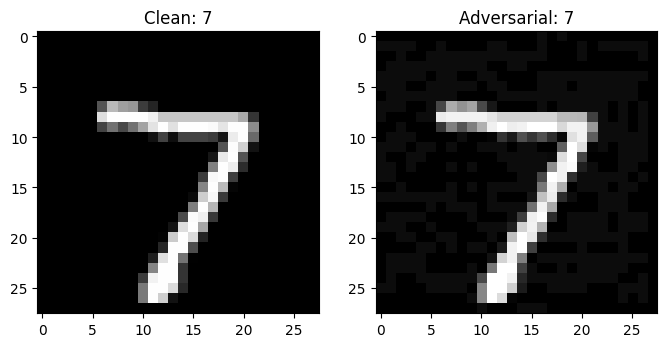

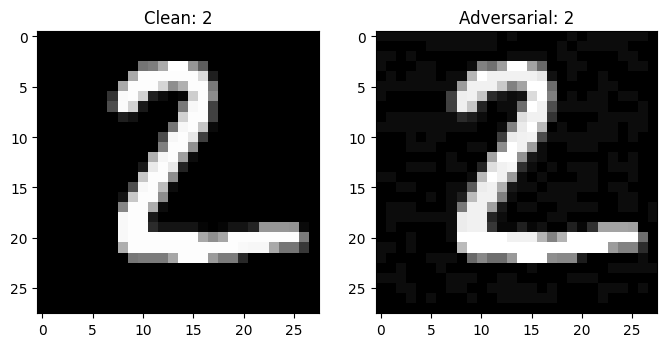

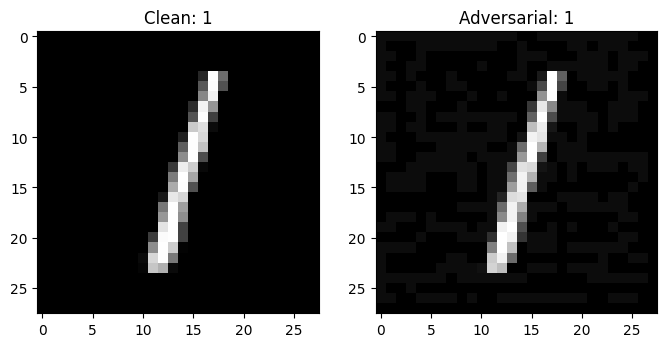

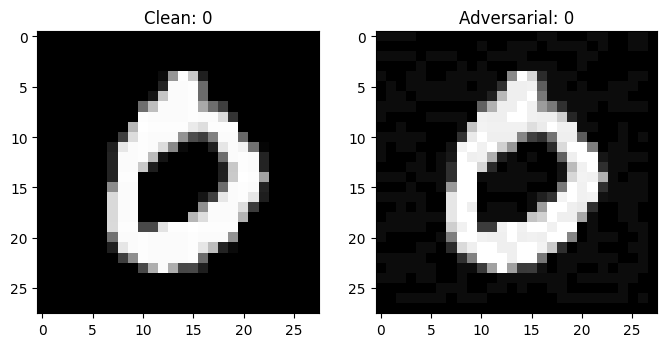

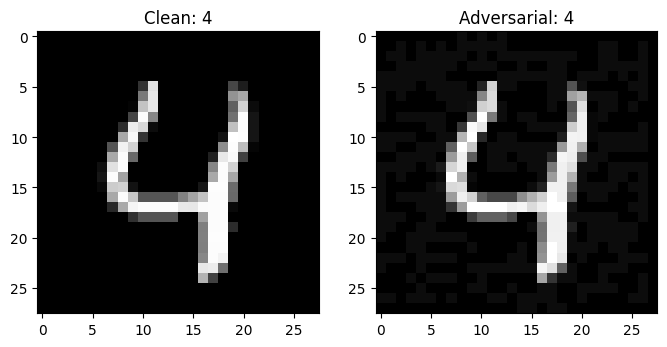

In [55]:
import matplotlib.pyplot as plt

# Visualize clean and adversarial examples
for i in range(5):
    plt.figure(figsize=(8, 4))
    # Clean image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Clean: {np.argmax(y_test[i])}")
    # Adversarial image
    plt.subplot(1, 2, 2)
    plt.imshow(x_test_adv[i].numpy().reshape(28, 28), cmap='gray')
    plt.title(f"Adversarial: {adv_pred_classes[i]}")
    plt.show()